# 尝试在MNIST数据集上建立一个分类器，使它在测试集上的精度超过97%。

提示： `KNeighborsClassifier` 非常适合这个任务。你只需要找出一个好的超参数值。

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings

warnings.filterwarnings('ignore', message=r".*?stochastic_gradient.*?")
%matplotlib inline

首先，定义一些必要的函数

In [21]:
def plot_img(image_data, shape=(28, 28)):
    """打印图片
    根据shape，打印图片
    :param image_data: `np.ndarray`. 图片信息
    :param shape: tuple. 图片的shape
    """
    plt.imshow(image_data.reshape(shape), cmap=matplotlib.cm.binary, interpolation='nearest')
    plt.axis('off')
    plt.show()

In [22]:
mnist_data = fetch_mldata("MNIST original")
train_index = 60000
X_train, X_test, y_train, y_test = mnist_data['data'][:train_index], mnist_data['data'][train_index:], mnist_data['target'][:train_index], mnist_data['target'][train_index:]
print("X train shape:", X_train.shape)
print("X test shape:", X_test.shape)
print("y train shape:", y_train.shape)
print("y test shape:", y_test.shape)

X train shape: (60000, 784)
X test shape: (10000, 784)
y train shape: (60000,)
y test shape: (10000,)


来随便看一张图片

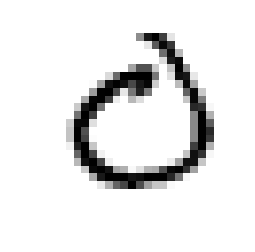

In [23]:
plot_img(X_train[665])

应该是0吧。

同时我们发现，很多的图片边缘都是空白的，因此，对这些边缘进行裁剪对我们的预测影响不大。

接下来，使用自定义 `Transformer` 进行维度缩减

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin


class PaddingDecomposor(BaseEstimator, TransformerMixin):
    def __init__(self, shape=None, padding=(None, None, None, None)):
        self.padding_ = padding
        self.de_shape_ = None  # 调整后的shape
        self.data_shape_ = shape  # 数据shape
    
    @staticmethod
    def _none2int(x):
        if x is None:
            return 0
        return abs(x)
    
    def _get_shape(self, x):
        if len(x.shape) == 2:
            d_x = x.shape[0] - self._none2int(self.padding_[0]) - self._none2int(self.padding_[1])
            d_y = x.shape[1] - self._none2int(self.padding_[2]) - self._none2int(self.padding_[3])
            self.de_shape_ = (d_x, d_y)
            return x.shape
        if len(x.shape) == 1:
            shape = int(np.sqrt(x.shape))
            if shape * shape != x.shape[0]:
                raise ValueError("x should be squared.")
            d_x = shape - self._none2int(self.padding_[0]) - self._none2int(self.padding_[1])
            d_y = shape - self._none2int(self.padding_[2]) - self._none2int(self.padding_[3])
            self.de_shape_ = (d_x * d_y, )
            return (shape, shape)
        raise ValueError("x demension must be 1 or 2.")
    
    def fit(self, X, y=None):
        _shape = self._get_shape(X[0])
        self.data_shape_ = self.data_shape_ or _shape
        return self
    
    def transform(self, X, y=None):
        m = X.shape[0]
        X_shape = (m, self.data_shape_[0], self.data_shape_[1])
        return X.reshape(X_shape)[:, self.padding_[0]: self.padding_[1], self.padding_[2]: self.padding_[3]].reshape((m, *self.de_shape_))

In [4]:
padding_decomposor = PaddingDecomposor(padding=(4, -4, 4, -4))
padding_decomposor.fit(X_train)
print(padding_decomposor.de_shape_, padding_decomposor.data_shape_, padding_decomposor.padding_)
print(X_train.shape)
X_train_pca = padding_decomposor.transform(X_train)
X_test_pca = padding_decomposor.transform(X_test)

(400,) (28, 28) (4, -4, 4, -4)
(60000, 784)


In [5]:
grid_params = {
    'n_neighbors': [3, 4, 5, 6],
    'weights': ['uniform', 'distance']
}
grid_search = GridSearchCV(KNeighborsClassifier(n_jobs=-1), grid_params, scoring='accuracy', cv=3, n_jobs=1, verbose=2)

In [7]:
knn_clf = KNeighborsClassifier(n_neighbors=4, weights='distance', algorithm='kd_tree')
knn_clf.fit(X_train_pca, y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='distance')

In [7]:
# grid_search.best_params_
{'n_neighbors': 4, 'weights': 'distance'}

{'n_neighbors': 4, 'weights': 'distance'}

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score

In [9]:
# y_pred = cross_val_score(knn_clf, X_train_pca, y_train, scoring='accuracy', cv=3)

In [9]:
y_test_pred = knn_clf.predict(X_test_pca)

In [11]:
print("Recall:", recall_score(y_test, y_test_pred, average="weighted"))
print("Precision:", precision_score(y_test, y_test_pred, average="weighted"))

Recall: 0.9728
Precision: 0.9730233225996623


来看看预测结果的混淆矩阵

In [18]:
cm = confusion_matrix(y_test, y_test_pred)
row_sum = cm.sum(axis=1, keepdims=True)
cm_ratio = cm / row_sum
np.fill_diagonal(cm_ratio, 0)

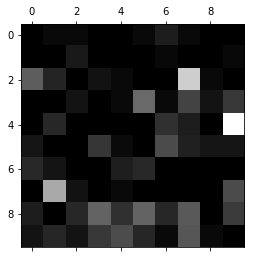

In [20]:
plt.matshow(cm_ratio, cmap=plt.cm.gray)

可以发现：
1. 4-9的地方尤其的亮，说明有很多4被预测成了9。
2. 7-1、2-7、3-5的地方有同样的预测问题。

# 写一个函数可以使MNIST中的图像任意方向移动

(上下左右)一个像素。然后对训练集上的每张图片，复制四个移动后的副本。这种人工扩大训练集的方法叫做数据增强，或者训练集扩张。

In [44]:
def pic_move(x, position='up', pixel=1):
    def move_up(x, pixel=1):
        add_arr = [x]
        add_arr.extend([[[0] * x.shape[1]]] * pixel)
        return np.concatenate(add_arr, axis=0)[pixel:, :]
    
    def move_down(x, pixel=1):
        add_arr = [[[0] * x.shape[1]]] * pixel
        add_arr.append(x)
        return np.concatenate(add_arr, axis=0)[:-pixel, :]
    
    def move_left(x, pixel=1):
        add_arr = [x]
        add_arr.extend([[[0]] * x.shape[0]] * pixel)
        return np.concatenate(add_arr, axis=1)[:, pixel:]
    
    def move_right(x, pixel=1):
        add_arr = [[[0]] * x.shape[0]] * pixel
        add_arr.append(x)
        return np.concatenate(add_arr, axis=1)[:, :-pixel]
    
    if position == 'up':
        return move_up(x, pixel)
    if position == 'down':
        return move_down(x, pixel)
    if position == 'left':
        return move_left(x, pixel)
    if position == 'right':
        return move_right(x, pixel)
    raise ValueError("position must be 'up', 'down', 'left' or 'right'")

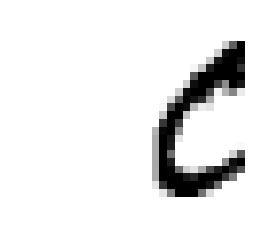

In [54]:
plot_img(pic_move(X_train[0].reshape(28, 28), position='right', pixel=10))

ok，图片往右移动了10个像素

现在来构建增强的训练集

In [64]:
X_train_large = []
y_train_large = []
for i, x in enumerate(X_train):
    for position in ('up', 'down', 'left', 'right'):
        X_train_large.append(pic_move(x.reshape(28, 28), position=position, pixel=1).reshape(784, ))
        y_train_large.append(y_train[i])
    X_train_large.append(x)
    y_train_large.append(y_train[i])
X_train_large = np.array(X_train_large)
y_train_large = np.array(y_train_large)

In [65]:
print("Large X train:", X_train_large.shape)
print("Large y train:", y_train_large.shape)

Large X train: (300000, 784)
Large y train: (300000,)


训练集由60000张扩大到了300000张

现在，我们看看数据增强能不能提高我们模型的表现

In [67]:
print("Use padding decomposor to decompose.")
X_train_large_pca = padding_decomposor.transform(X_train_large)
print("Start training model.")
knn_clf_large = KNeighborsClassifier(n_neighbors=4, weights='distance', algorithm='kd_tree')
knn_clf_large.fit(X_train_large_pca, y_train_large)

Use padding decomposor to decompose.
Start training model.


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='distance')

Recall: 0.9776
Precision: 0.9777641362178134


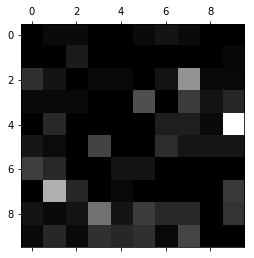

In [69]:
y_test_pred_large = knn_clf_large.predict(X_test_pca)
print("Recall:", recall_score(y_test, y_test_pred_large, average="weighted"))
print("Precision:", precision_score(y_test, y_test_pred_large, average="weighted"))
cm = confusion_matrix(y_test, y_test_pred_large)
row_sum = cm.sum(axis=1, keepdims=True)
cm_ratio_large = cm / row_sum
np.fill_diagonal(cm_ratio_large, 0)
_ = plt.matshow(cm_ratio_large, cmap=plt.cm.gray)

不错，好了零点几个百分点。

但是预测效率变得如此之慢，在这个项目中，是否值得我们这样做呢？

# Titanic

不做了，在其他地方做过了

# 垃圾邮件分类器

In [425]:
import os
import re

from lxml import etree
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import pandas as pd
from pattern.en import lemma
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion

In [222]:
def _load_all(path):
    for filename in os.listdir(path):
        if filename.startswith('.'):
            continue
        with open(os.path.join(path, filename), 'r', encoding='utf8', errors='ignore') as f:
            content = f.read()
        yield content


def load_spam(name='all'):
    all_names = {
        'easy_ham': 0, 
        'hard_ham': 0, 
        'spam_2': 1
    }
    base_path = '/Users/heyao/Desktop/mllearn/mllearn/notebooks/hands-on-ml-with-sklearn-and-tf/datasets/spam_email/'
    if name == 'all':
        name = list(all_names.keys())
    if not isinstance(name, (list, tuple)):
        name = [name]
    for n in name:
        if n not in all_names:
            raise ValueError("name must be %s or all" % ', '.join(name))
    X = []
    y = []
    for n in name:
        emails = list(_load_all(os.path.join(base_path, n)))
        X.extend(emails)
        y.extend([all_names[n]] * len(emails))
    data = {'data': X, 'target': y}
    return data

In [223]:
spam_data = load_spam('all')

In [220]:
X, y = spam_data['data'], spam_data['target']

In [221]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X train length:", len(X_train))
print("X test length:", len(X_test))

X train length: 3358
X test length: 840


## 一些工具类

In [452]:
def extract_email_body(email, gap=6):
    def _maybe_header(line):
        if ': ' in line and all(i.istitle() for i in line.split(':')[0].split('-')):
            return True
        return False
    st = 0
    bingo = 0
    for line in email.split('\n'):
        st += 1
        bingo += 1
        if not line:
            continue
        if bingo == gap:
            st -= gap
            break
        if _maybe_header(line):
            bingo = 0
            continue
    return st + 1


class EmailFeatureExtractor(BaseEstimator, TransformerMixin):
    RE_URL = re.compile(r"(https?|ftp|file)://[-A-Za-z0-9+&@#/%?=~_|!:,.;]+[-A-Za-z0-9+&@#/%=~_|]")
    
    RE_NUMBER = re.compile(r"[0-9]{0,}\.{0,1}[0-9]{1,}")
    
    RE_PROCESS = [
        (re.compile(r"\*{1,}"), "*"),
        (re.compile(r"\-{1,}"), "-"),
        (re.compile(r"_{1,}"), "_"),
        (re.compile(r"_"), " ")
    ]
    
    PUNCTUATIONS = set(list(".?!,'\"{}[]()*&^%$#@~"))
    
    def __init__(self, counter='binary', preprocess=True, stem=False, remove_headers=True, lower=False, 
                 punctuation=False, url=False, number=False, remove_html=True):
        self.counter_ = counter
        self.preprocess_ = preprocess
        self.stem_ = stem
        self.remove_headers_ = remove_headers
        self.lower_ = lower
        self.punctuation_ = punctuation
        self.url_ = url
        self.number_ = number
        self.remove_html_ = remove_html
        self.count_vectorizer = None
        self.tfidf_vectorizer = None
        
    def _preprocess(self, X):
        if self.preprocess_:
            X_ = []
            for x in X:
                for reg in self.RE_PROCESS:
                    x = reg[0].sub(reg[1], x)
                X_.append(x)
            return X_
        return X
    
    def _tokenize(self, X):
        return [word_tokenize(x) for x in X]
    
    def _lemma(self, X):
        # 暂时没有实现
        if self.stem_:
            return [[lemma(i) for i in x] for x in X]
        return X
    
    def _remove_headers(self, X):
        if self.remove_headers_:
            return ['\n'.join(x.split('\n')[extract_email_body(x):None]) for x in X]
        return X
    
    def _lower(self, X):
        if self.lower_:
            return [x.lower() for x in X]
    
    def _punctuation(self, X):
        if self.punctuation_:
            return [[i for i in x if i not in self.PUNCTUATIONS] for x in X]
        return X
    
    def _url(self, X):
        if self.url_:
            return [self.RE_URL.sub("URL", x) for x in X]
        return X
    
    def _number(self, X):
        if self.number_:
            return [self.RE_NUMBER.sub("NUMBER", x) for x in X]
        return X
    
    @staticmethod
    def __rm_html(x):
        if '<html>' not in x.lower():
            return x
        sel = etree.HTML(x)
        return '\n'.join(p.strip() for p in sel.xpath('//text()') if p.strip())
    
    def _remove_html(self, X):
        if self.remove_html_:    
            return [self.__rm_html(x) for x in X]
        return X
    
    def pipeline(self, X):
        X = self._preprocess(X)
        X = self._remove_headers(X)
        X = self._remove_html(X)
        X = self._url(X)
        X = self._number(X)
        X = self._lower(X)
        X = self._tokenize(X)
        X = self._punctuation(X)
        X = self._lemma(X)
        return X
    
    def fit(self, X, y=None):
        X = self.pipeline(X)
        count_vectorizer = CountVectorizer(lowercase=False, binary=(self.counter_ == 'binary'), 
                                           ngram_range=(1, 1), stop_words='english')
        X = [' '.join(x) for x in X]
        count_vectorizer.fit(X)
        self.count_vectorizer = count_vectorizer
        if self.counter_ == 'tfidf':
            tfidf_transformer = TfidfTransformer()
            tfidf_transformer.fit(count_vectorizer.transform(X))
            self.tfidf_transformer = tfidf_transformer
        return self
    
    def transform(self, X, y=None):
        X = self.pipeline(X)
        X = [' '.join(x) for x in X]
        X = self.count_vectorizer.transform(X)
        if self.counter_ == 'tfidf':
            X = self.tfidf_transformer.transform(X)
        return X

In [453]:
class EmailStructureExtractor(BaseEstimator, TransformerMixin):
    RE_SENDER = re.compile(r"FROM: (.*?)")
    
    def __init__(self):
        self.feature_names_ = None
    
    def _remove_headers(self, X):
        return ['\n'.join(x.split('\n')[extract_email_body(x):None]) for x in X]
    
    def _extract_feature(self, x):
        item = {}
        total_img = int(x.count('<img'))
        item['total_img'] = total_img
        return item
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = self._remove_headers(X)
        X = [self._extract_feature(x) for x in X]
        df = pd.DataFrame(X)
        self.feature_names_ = list(df.columns)
        return df.values

## 构建pipeline

In [428]:
# email_transformer = EmailFeatureExtractor(counter='tfidf', lower=True, url=True, number=True)

In [460]:
email_pipeline = Pipeline([
    ('email_transformer', EmailFeatureExtractor(counter='tfidf', stem=True, punctuation=True, 
                                                remove_headers=False, lower=True, url=True, number=True))
])
structure_pipeline = Pipeline([
    ('structure', EmailStructureExtractor())
])
full_pipeline = FeatureUnion([
    ('text_pipeline', email_pipeline),
    ('structure_pipeline', structure_pipeline)
])

In [461]:
full_pipeline.fit(X_train)
X_train_feature = full_pipeline.transform(X_train)
X_test_feature = full_pipeline.transform(X_test)
print("X train feature shape:", X_train_feature.shape)

X train feature shape: (3358, 65924)


## 开始构建模型

In [300]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict

In [462]:
model = LogisticRegressionCV(Cs=10, cv=5, n_jobs=-1, random_state=42)
model.fit(X_train_feature, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=-1, penalty='l2', random_state=42,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [466]:
# y_train_pred = cross_val_predict(model, X_train_feature, y_train, cv=3, n_jobs=1)
y_train_pred = model.predict(X_train_feature)

In [467]:
print(classification_report(y_train, y_train_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      2221
          1       1.00      1.00      1.00      1137

avg / total       1.00      1.00      1.00      3358



In [468]:
confusion_matrix(y_train, y_train_pred)

array([[2221,    0],
       [   0, 1137]])

交叉验证之后的结果如此的好，那么可以放心的上线了

下面，使用测试集估计一下实际环境中，该模型的效果如何

In [469]:
y_test_pred = model.predict(X_test_feature)
print(classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

          0       1.00      0.99      0.99       580
          1       0.98      1.00      0.99       260

avg / total       0.99      0.99      0.99       840



加上headers居然直接让结果达到了如此高的精度